In [3]:
import os
os.chdir(r"D:\Abhinav Tar Files\Snapshots")

Processed 100.0% of particles
Potential energy values: [np.float64(-2.722294141729576e-08), np.float64(-2.621384302211668e-05), np.float64(-5.167599474273544e-05), np.float64(-7.73270025381483e-05), np.float64(-0.0001017066354556986), np.float64(-0.00012566262390640635), np.float64(-0.0001487725124680648), np.float64(-0.00017237583797924492), np.float64(-0.00019454657346190543), np.float64(-0.00021843817339347384), np.float64(-0.00024141742236490673), np.float64(-0.00026345719497145194), np.float64(-0.00028528469191129536), np.float64(-0.0003072438314184279), np.float64(-0.00032944114604044073), np.float64(-0.000351622340263912), np.float64(-0.00037224537488224), np.float64(-0.00039224301635811047), np.float64(-0.0004128202259795643), np.float64(-0.0004325026001666107), np.float64(-0.0004533309831263138), np.float64(-0.00047312341315481726), np.float64(-0.0004923952915371345), np.float64(-0.000511754627806731), np.float64(-0.0005299492896306242), np.float64(-0.0005492257532423948), np.

OSError: [Errno 22] Invalid argument: 'potential_energy_progress_snapshot445.png'

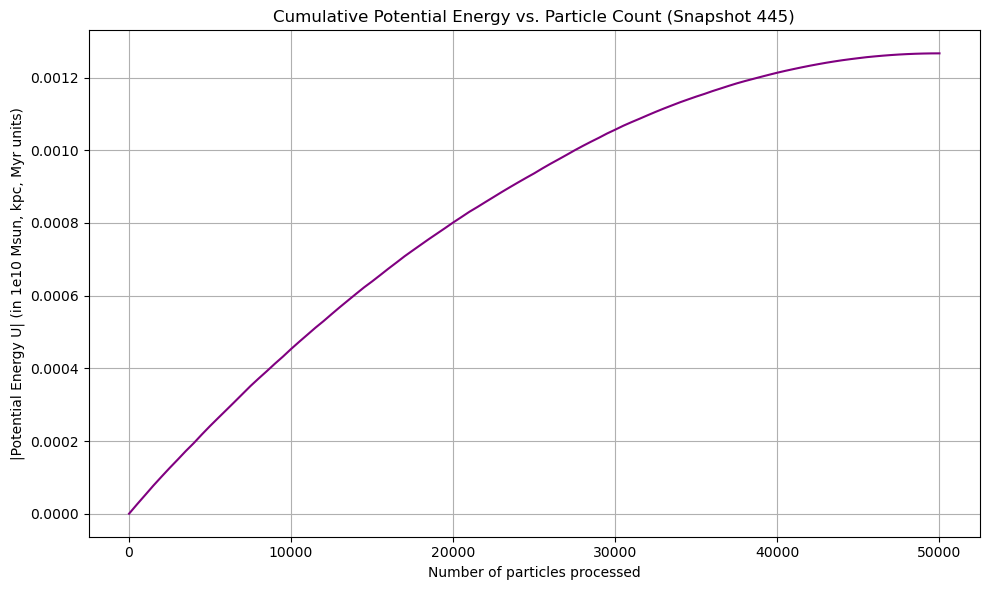

In [4]:
import numpy as np
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

G = 4.498e-6

snap = 445 # Merger Snapshot
mw_file = f"MW_{snap:03d}.txt"
m31_file = f"M31_{snap:03d}.txt"

MW = CenterOfMass(mw_file, 1)
M31 = CenterOfMass(m31_file, 1)

x = np.concatenate((MW.x, M31.x))
y = np.concatenate((MW.y, M31.y))
z = np.concatenate((MW.z, M31.z))
vx = np.concatenate((MW.vx, M31.vx))
vy = np.concatenate((MW.vy, M31.vy))
vz = np.concatenate((MW.vz, M31.vz))
m = np.concatenate((MW.m, M31.m))

pos = np.vstack((x, y, z)).T
vel = np.vstack((vx, vy, vz)).T

xcom, ycom, zcom = MW.COMdefine(x, y, z, m)
vxcom, vycom, vzcom = MW.COMdefine(vx, vy, vz, m)
pos -= np.array([xcom, ycom, zcom])
vel -= np.array([vxcom, vycom, vzcom])

def potential_energy_progress(positions, masses, show_progress=True):
    tree = cKDTree(positions)
    N = len(masses)
    U = 0.0
    U_progress = []
    particle_counts = []

    for i, pos in enumerate(positions):
        dists, idxs = tree.query(pos, k=N, distance_upper_bound=np.inf)
        for r, j in zip(dists, idxs):
            if j <= i or r == 0 or np.isinf(r):
                continue
            U -= G * masses[i] * masses[j] / r
        if i % max(N // 100, 1) == 0 or i == N-1:
            U_progress.append(U)
            particle_counts.append(i+1)
            if show_progress:
                percent = (i + 1) / N * 100
                print(f"Processed {percent:.1f}% of particles", end='\r')
    print()
    print("Potential energy values:", U_progress)
    return np.array(particle_counts), np.array(U_progress)

particle_counts, U_progress = potential_energy_progress(pos, m, show_progress=True)

plt.figure(figsize=(10,6))
plt.plot(particle_counts, np.abs(U_progress), color='purple')
plt.xlabel("Number of particles processed")
plt.ylabel("|Potential Energy U| (in 1e10 Msun, kpc, Myr units)")
plt.title(f"Cumulative Potential Energy vs. Particle Count (Snapshot {snap})")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"potential_energy_progress_snapshot{snap}.png", dpi=300)
plt.show()
